In [78]:
import numpy as np
import pandas as pd
import datetime
import time

import matplotlib.pyplot as plt
%matplotlib inline


# read data
we are reading the dataframe and printing out head and tail of the frame to get a notion of how much data we are dealing with

In [3]:
df  = pd.read_csv('bitstampUSD_original.csv')

In [31]:
print( df.head() )
print( df.tail() )
print(df.dtypes)


    timestamp  price   volume
0  1315922024   5.83   3.0000
1  1315922029   5.90   1.0000
2  1315922034   6.00  20.0000
3  1315924373   5.95  12.4521
4  1315924504   5.88   7.4580
           timestamp    price    volume
12368409  1499984555  2349.00  0.011628
12368410  1499984555  2350.00  1.000000
12368411  1499984557  2349.00  1.000000
12368412  1499984593  2345.86  0.100000
12368413  1499984604  2348.99  0.139533
timestamp      int64
price        float64
volume       float64
dtype: object


# hadnling time
We need helper functions to convert from timestamp format to printed format and vise-verse to be able to cut out interesting parts of the dataset.

In [28]:

def timestamp_to_datetime( timestamp ):
    ret = datetime.datetime.fromtimestamp( int(timestamp) )
    return ret

def datetime_to_timestamp( myDateString ):
    d_time= datetime.datetime.strptime(myDateString,"%Y-%m-%d %H:%M:%S")
    return int( time.mktime(d_time.timetuple()))
    
df.columns = ['timestamp','price','volume']
print(timestamp_to_datetime(df['timestamp'].iloc[0]))
print(timestamp_to_datetime(df['timestamp'].iloc[-1]))


2011-09-13 15:53:44
2017-07-14 00:23:24


In [30]:
print(datetime_to_timestamp('2011-09-13 15:53:44'))
print(datetime_to_timestamp('2017-07-14 00:23:24'))

1315922024
1499984604


# cut data:
We are currently only interested in the data for 2016 just to have something to play with. Data from 2017 can later be used for verification of the models we find for 2016.

In [56]:
def slice_df_by_date(df_in, date_start, date_end):
    timestamp_start = datetime_to_timestamp(date_start)
    timestamp_end = datetime_to_timestamp(date_end)
    df_out = df.where( df['timestamp']>timestamp_start )
    df_out = df_out.where(df['timestamp']<timestamp_end )
    df_out.dropna(inplace=True)
    
    return df_out
    
df_cut = slice_df_by_date(df,'2016-01-01 00:00:00','2017-01-01 00:00:00' )
df_cut.head()

,timestamp,price,volume
8547848,1.451603e+09,431.29,0.126287
8547849,1.451603e+09,431.04,0.067812
8547850,1.451603e+09,431.04,0.042022
8547851,1.451603e+09,430.34,0.538321
8547852,1.451603e+09,430.33,0.147512


df_cut.tail()


In [57]:
 def groupByTime(df_in, groupFreqency ='1min'):
    df_in['datetime'] = pd.to_datetime(df_in['timestamp'],unit='s')
    df_out = df_in.set_index('datetime')
    df_out = df_out.groupby(pd.TimeGrouper( groupFreqency) ).agg({'price':np.mean,'volume':np.sum})
    df_out['price'].ffill(inplace=True)
    df_out['volume'].fillna(0,inplace=True)
    return df_out

df_cut_grouped = groupByTime(df_cut)
df_cut_grouped.tail()

,volume,price
datetime,,
2016-12-31 22:55:00,0.159594,964.000
2016-12-31 22:56:00,0.000000,964.000
2016-12-31 22:57:00,0.000000,964.000
2016-12-31 22:58:00,21.000000,963.580
2016-12-31 22:59:00,0.811275,963.986


In [58]:
df_cut_grouped['pct_change'] = df_cut_grouped['price'].pct_change()

In [61]:
df_cut_grouped.tail()

,volume,price,pct_change
datetime,,,
2016-12-31 22:55:00,0.159594,964.000,0.000000
2016-12-31 22:56:00,0.000000,964.000,0.000000
2016-12-31 22:57:00,0.000000,964.000,0.000000
2016-12-31 22:58:00,21.000000,963.580,-0.000436
2016-12-31 22:59:00,0.811275,963.986,0.000421


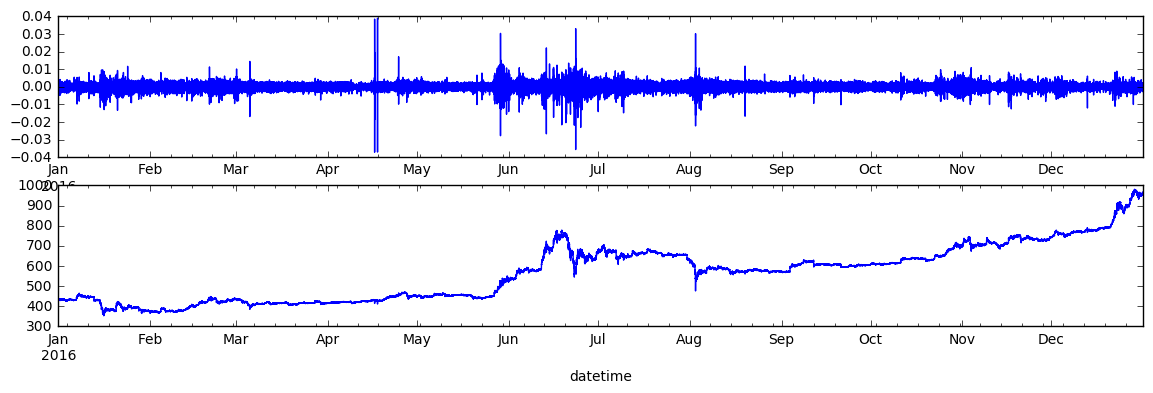

In [128]:
plt.subplot(2,1,1)
df_cut_grouped['pct_change'].plot(figsize=(14,4))
plt.subplot(2,1,2)
df_cut_grouped['price'].plot(figsize=(14,4))

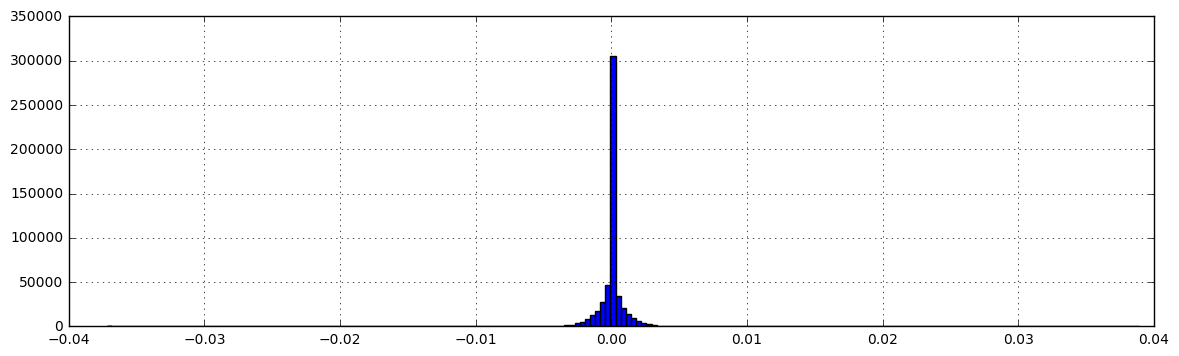

In [87]:

df_cut_grouped['pct_change'].hist(bins = 201,figsize=(14,4))

# wait period
We konw that the cost is about 0.2% / trade for both selling and buying currencies.By calculating the standard deviation of the percent change per minute, we can see that in the price will change 0.2% in about 2 min and 23 seconds for 68% of all changes. 


In [101]:
df_cut_grouped.dropna(inplace=True)
desc = df_cut_grouped.describe()
desc

,volume,price,pct_change
count,527035.000000,527035.000000,527035.000000
mean,3.780001,565.756297,0.000002
std,16.254794,137.303253,0.000933
min,0.000000,352.335385,-0.037154
25%,0.000000,430.542727,-0.000038
50%,0.173862,579.910000,0.000000
75%,1.566665,661.600000,0.000070
max,1430.761155,980.740000,0.038925


In [104]:
print('percent change per minute:' , 0.002/desc['pct_change']['std'])
print('print, every 2 min and ', 0.14*100/60, 'seconds')

percent change per minute: 2.14410518714
print, every 2 min and  0.23333333333333336 seconds


In [126]:
start_idx = 72000
end_idx = 73001

print( 'startprice', df_cut_grouped['price'].iloc[start_idx],'endprice',df_cut_grouped['price'].iloc[end_idx])
pricechange = (df_cut_grouped['price'].iloc[end_idx] - df_cut_grouped['price'].iloc[start_idx])/df_cut_grouped['price'].iloc[start_idx]
print('pricechange:',pricechange )


df_cut_grouped['pct_change'].iloc[start_idx:end_idx].sum()


startprice 418.8175 endprice 429.05
pricechange: 0.0244318826219


0.02370045670959775

So, we can use the sum() function to approximate the gain/loss. There is a drift ofcause because we don't calculate the cumulative product. eg, if we in first sample gain 10% and in next gain another 10% we should end up 1.1 x 1.1 = 1.21. but since we calculate the sum, we will only gain gain 20% not 21 as for real.

In [129]:
type(df)

pandas.core.frame.DataFrame

In [130]:
a = 10
type(a)

int